In [1]:
# importing the necessary libraries
import pandas as pd
import matplotlib.pyplot  as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from pmdarima import auto_arima

In [2]:
# Read the data
df = pd.read_csv('Bakery_sales.csv')
df.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


**DATA ANALYSIS**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


In [4]:
# checking for null values
df.isnull().sum()

Unnamed: 0       0
date             0
time             0
ticket_number    0
article          0
Quantity         0
unit_price       0
dtype: int64

In [5]:
# checking for duplicate values
df.duplicated().sum()

0

In [6]:
# dropping negative values
df = df[df['Quantity'] >= 0]

In [7]:
# dropping the first column
df = df.drop(df.columns[0], axis=1)

In [8]:
# checking for the unique values of the article column
df['article'].value_counts()

article
TRADITIONAL BAGUETTE      67349
COUPE                     20386
BAGUETTE                  15225
BANETTE                   15020
CROISSANT                 11448
                          ...  
REDUCTION SUCREES 24          1
PAIN NOIR                     1
BUCHE 8PERS                   1
DOUCEUR D HIVER               1
SACHET DE VIENNOISERIE        1
Name: count, Length: 149, dtype: int64

In [9]:
#converting date to datetime
df['date'] = pd.to_datetime(df['date'])

# setting date as the index
df.set_index('date', inplace=True)

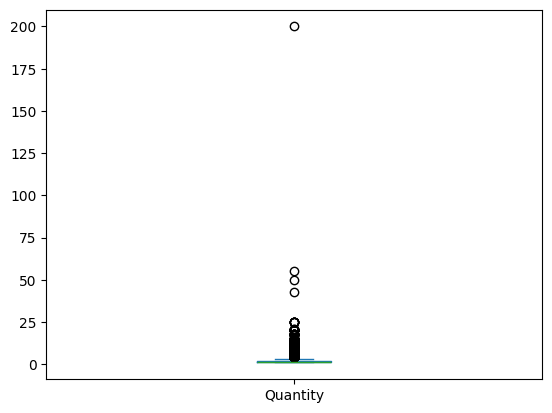

In [10]:
# plotting the data to a boxplot to check for outliers
df['Quantity'].plot(kind='box')
plt.show()

Since there are no points beyond the whiskers, then it indicates that there are no outliers in our data

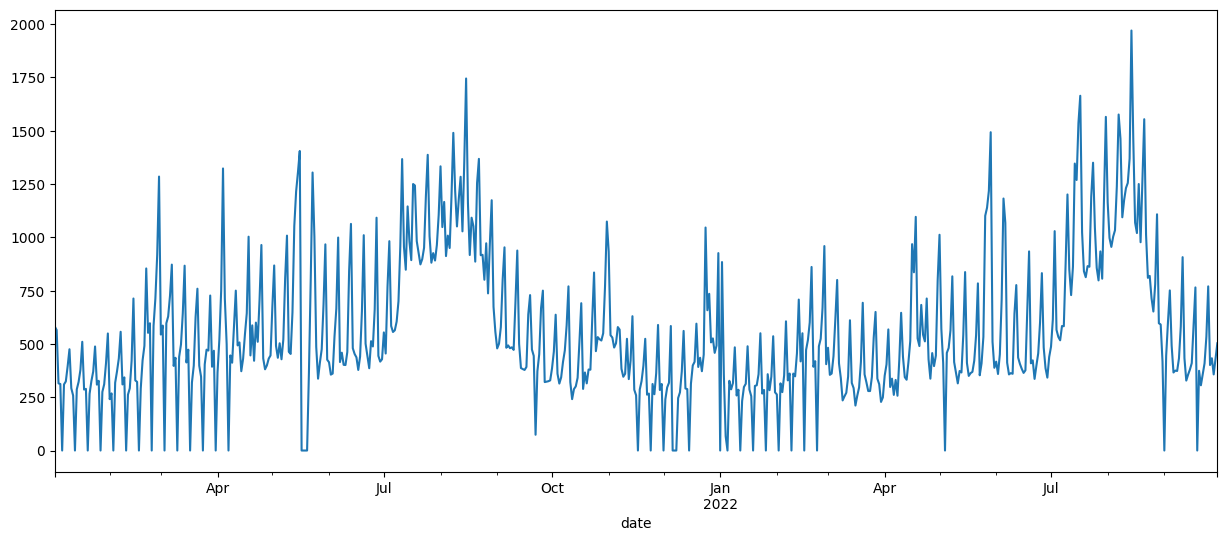

In [11]:
# plotting the daily sales data
daily_sales = df['Quantity'].resample('D').sum()
daily_sales.plot(figsize=(15, 6))
plt.show()


As can be seen on the graph, there are noticeable spikes on sales during the month of August and September

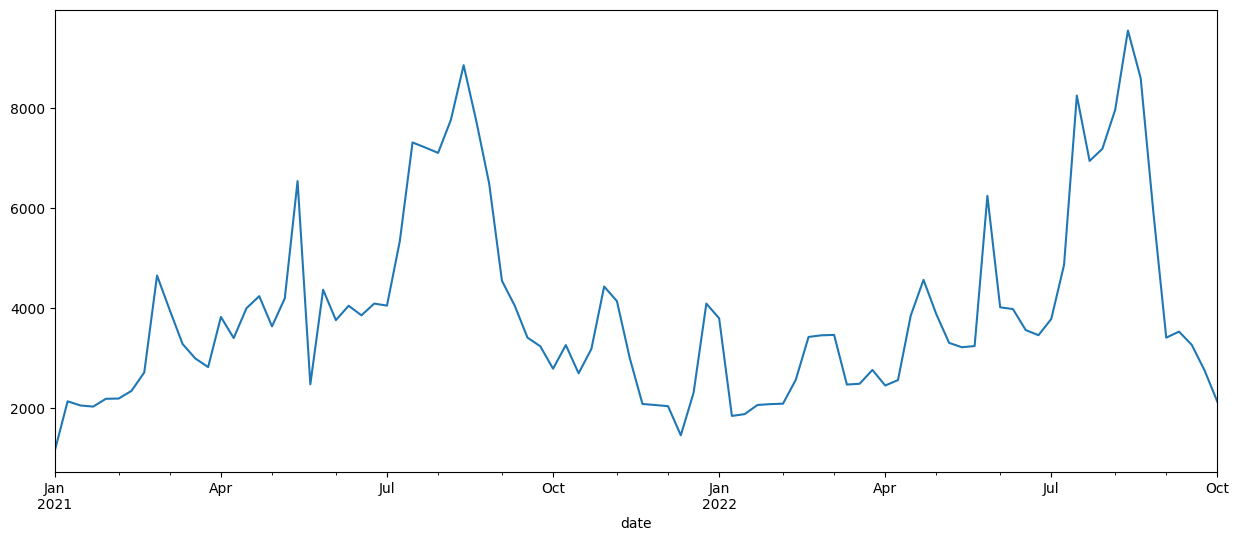

In [12]:
# plotting the weekly sales data
weekly_sales = df['Quantity'].resample('W').sum()
weekly_sales.plot(figsize=(15, 6))
plt.show()

The same trend can also be seen on the graph of the weekly sales data

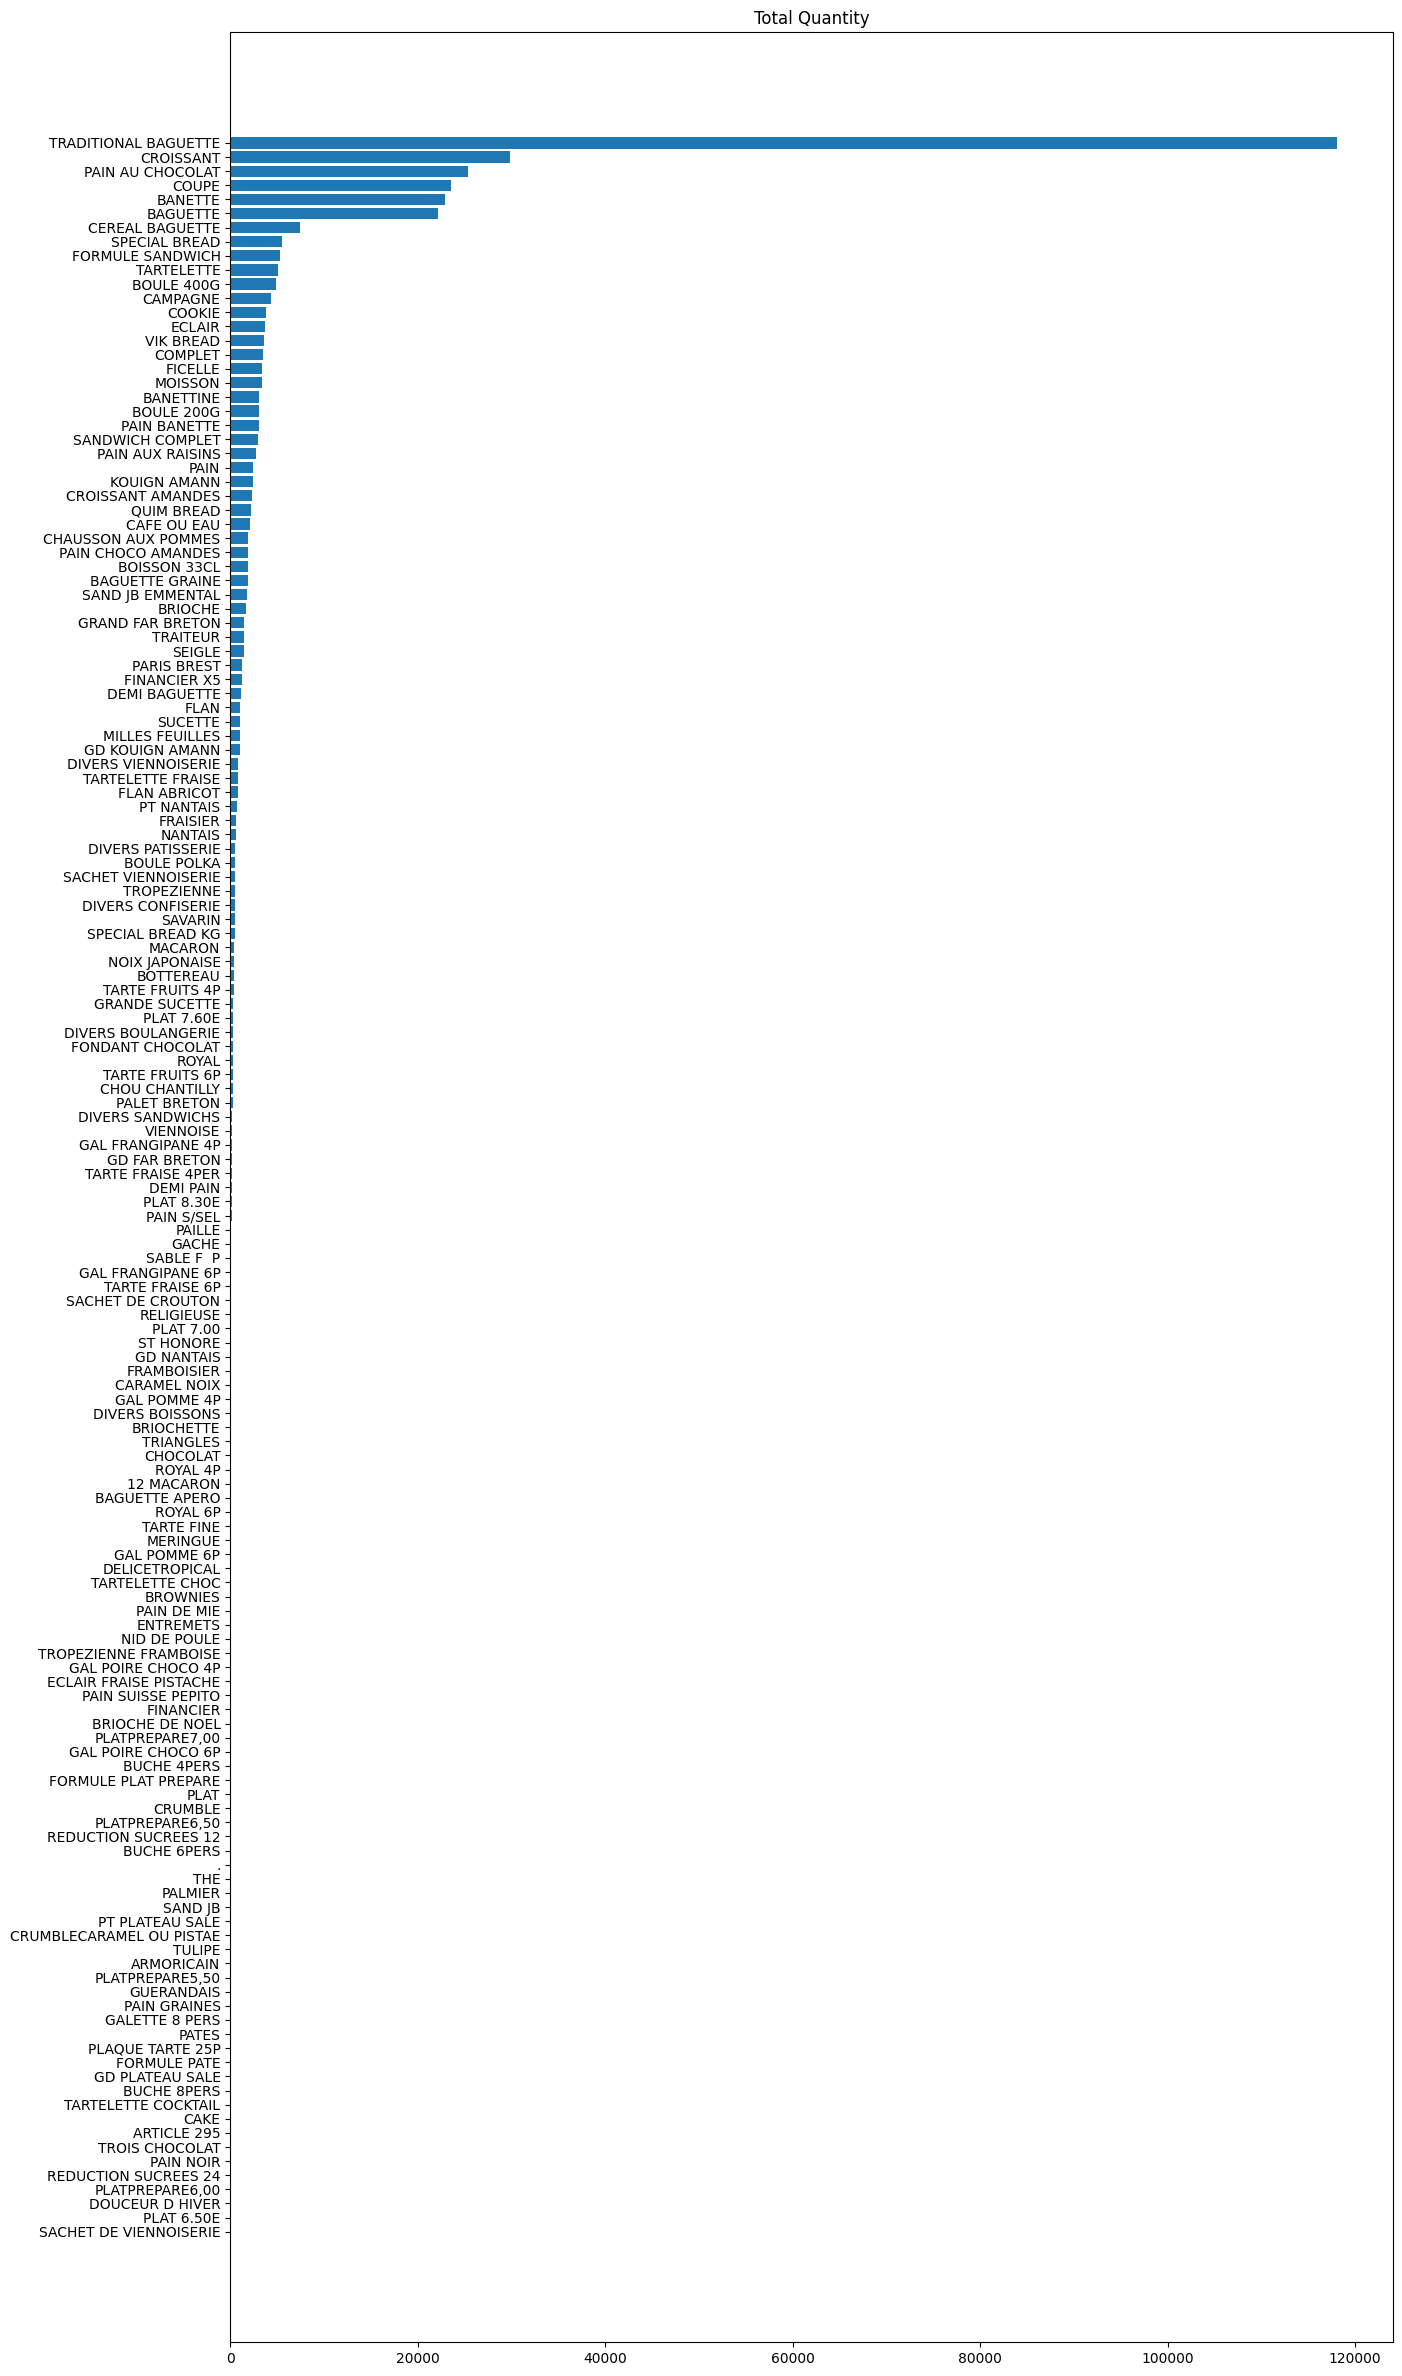

In [13]:
# creating a table of total quantity of sales per unit
sum_quantity = df.groupby('article').agg({'Quantity':'sum'}).sort_values(by = 'Quantity', ascending = True).reset_index()

# creating horizontal bar chart of quantity
fig, ax = plt.subplots()

ax.barh(sum_quantity['article'], sum_quantity['Quantity'])
ax.set_title('Total Quantity')

fig.set_figwidth(15)
fig.set_figheight(30)


Analyzing which products has the highest sales, noting that the traditional baguette being the best seller by a wide margin

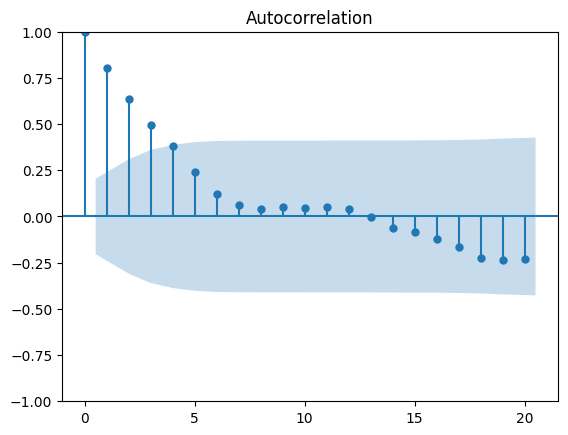

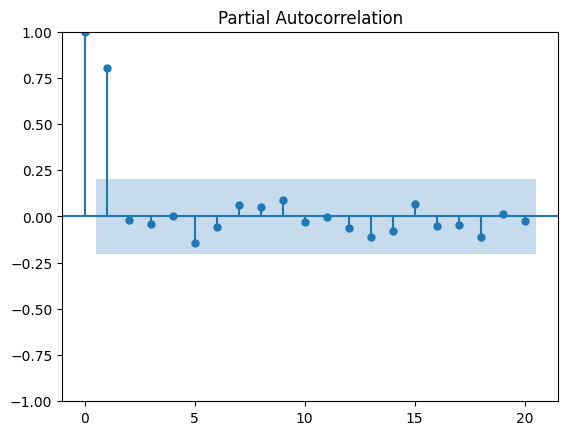

In [14]:
# Plot the ACF and PACF
plot_acf(weekly_sales)
plt.show()

plot_pacf(weekly_sales)
plt.show()

As can be noted in both the ACF and PCF plot, there are time period wherein there will be positive and negative spike. This pattern of autocorrelation suggests that the variable has a seasonal trend. In other words, the variable tends to repeat itself over a certain period of time.

In [15]:
# performing augmented dickey-fuller test
result = adfuller(weekly_sales.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.110032
p-value: 0.025820
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


Since the p-value is less than 0.05, it is safe to assume that the data is stationary

In [16]:
# returns the top 10 articles with the highest sales
top_6 = df.groupby('article').agg({'Quantity':'sum'}).sort_values(by = 'Quantity', ascending = False).head(6).reset_index()

print(top_6)

                article  Quantity
0  TRADITIONAL BAGUETTE  118093.0
1             CROISSANT   29822.0
2      PAIN AU CHOCOLAT   25367.0
3                 COUPE   23601.0
4               BANETTE   22870.0
5              BAGUETTE   22156.0


Since there are too many unique values in the article column, we are only going to convern ourselves with the top 6 best selling products as the others don't have enough data about them to be able to make a reliable model

**MODEL CREATION USING SARIMAX**

In [17]:
# Auto-ARIMA is used to find the best parameter for the model

#model_auto_arima = auto_arima(train, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
#                max_p=5, max_q=5, max_P=3, max_Q=3, seasonal=True, maxiter=50,m = 52, D = 1,
#                information_criterion='aic',stepwise=True, suppress_warnings=True,
#                error_action='ignore',approximation = False)
#model_auto_arima.fit(train)

C:\Users\Rodney\AppData\Local\Temp\ipykernel_18760\208125199.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


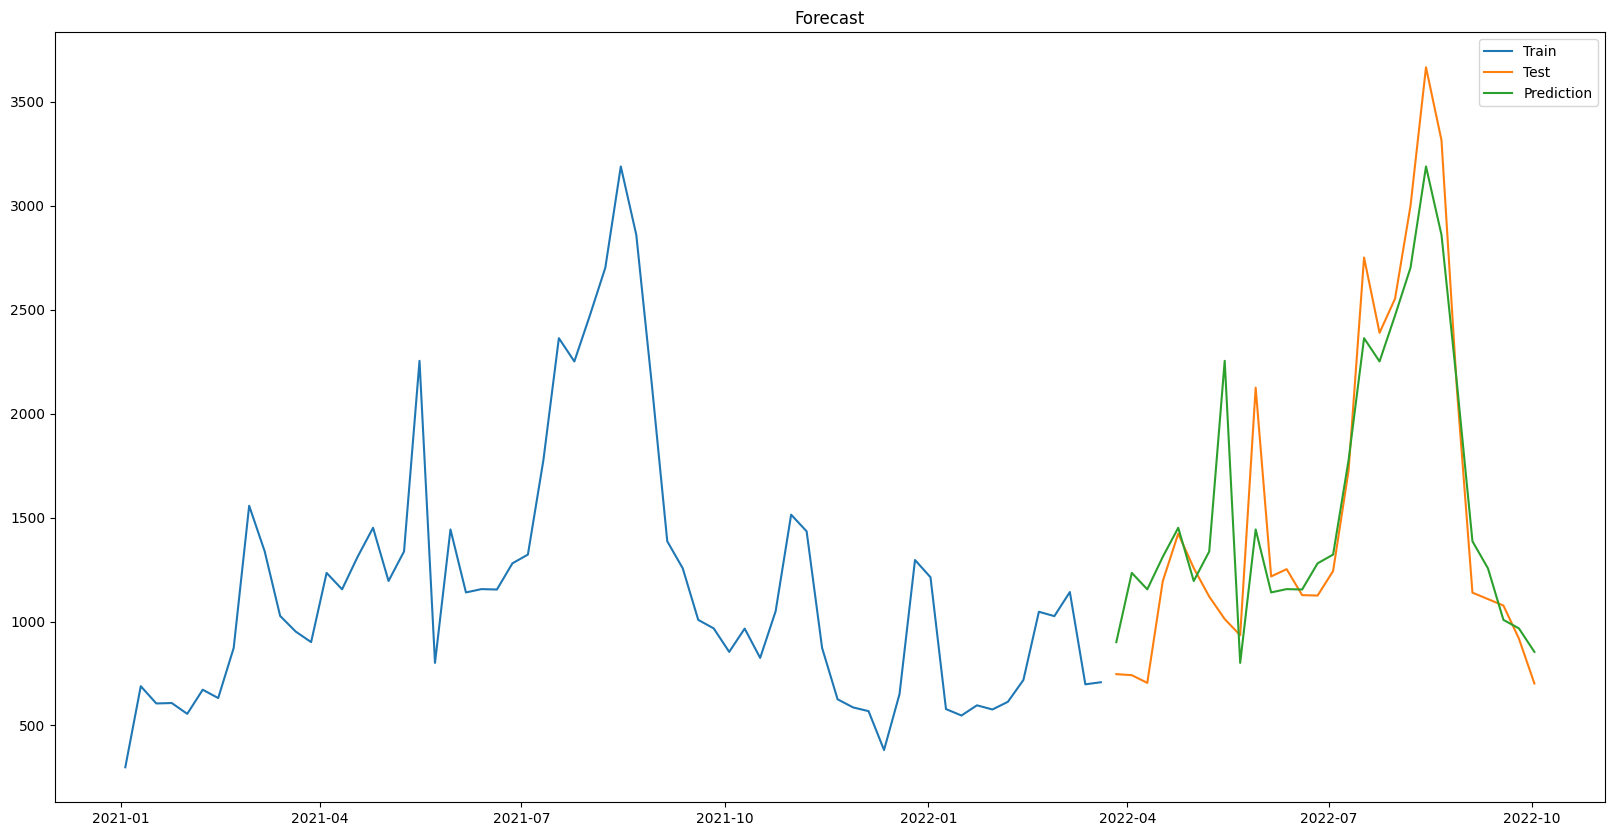

In [18]:
# creating a df of the given article
product = df[df['article'] == 'TRADITIONAL BAGUETTE']

# resampling the data to weekly
weekly_sales = product['Quantity'].resample('W').sum()

# splitting the data into train and test
train = weekly_sales[:int(0.7*len(weekly_sales))]
test = weekly_sales[int(0.7*len(weekly_sales)):]

# Result: order=(0,0,0), seasonal_order=(0,1,0,52)

# fitting the model
model = SARIMAX(train, order=(0,0,0), seasonal_order=(0,1,0,52))
model_fit = model.fit()

# predicting the values
prediction = pd.DataFrame(model_fit.predict(start= len(train), end=(len(train) + len(test) - 1))).set_index(test.index)

# plotting the results
fig, ax = plt.subplots()

ax.plot(train, label = "Train")
ax.plot(test, label = 'Test')
ax.plot(prediction, label = 'Prediction')
ax.set_title('Forecast')
ax.legend()

fig.set_figwidth(20)
fig.set_figheight(10)
fig.show()

In [19]:
# calculating the r2 score
r2 = r2_score(test, prediction)
print('r2 score: {}'.format(r2))

r2 score: 0.8197409730226015


C:\Users\Rodney\AppData\Local\Temp\ipykernel_18760\2074125653.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


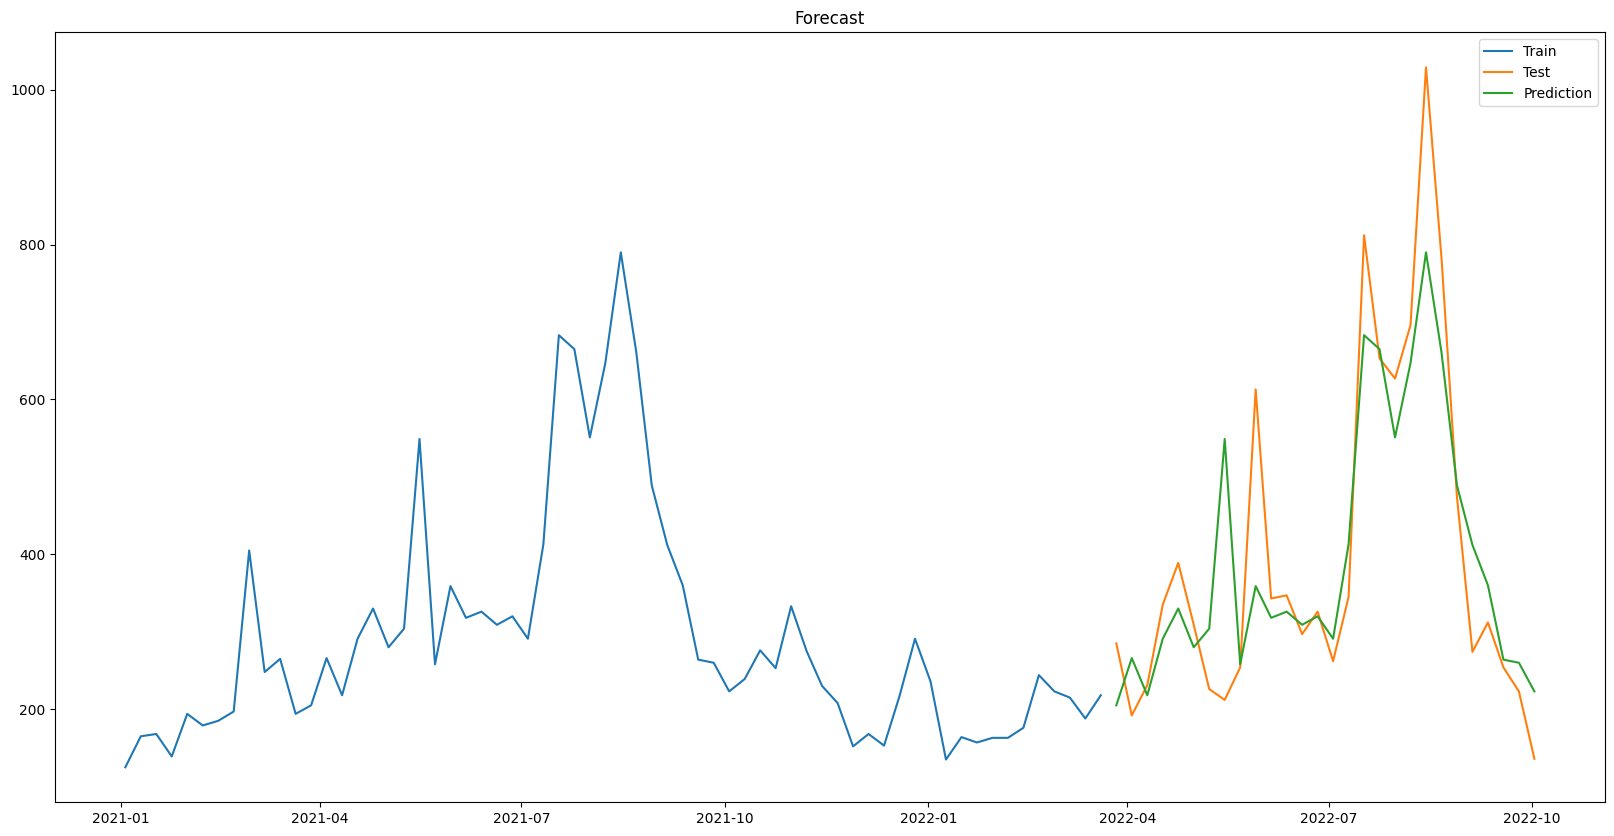

In [20]:
product = df[df['article'] == 'CROISSANT']

weekly_sales = product['Quantity'].resample('W').sum()

train = weekly_sales[:int(0.7*len(weekly_sales))]
test = weekly_sales[int(0.7*len(weekly_sales)):]

#Result: order=(0,0,0), seasonal_order=(0,1,0,52)

model = SARIMAX(train, order=(0,0,0), seasonal_order=(0,1,0,52))
model_fit = model.fit()

prediction = pd.DataFrame(model_fit.predict(start= len(train), end=(len(train) + len(test) - 1))).set_index(test.index)

fig, ax = plt.subplots()

ax.plot(train, label = "Train")
ax.plot(test, label = 'Test')
ax.plot(prediction, label = 'Prediction')
ax.set_title('Forecast')
ax.legend()

fig.set_figwidth(20)
fig.set_figheight(10)
fig.show()

In [21]:
r2 = r2_score(test, prediction)
print('r2 score: {}'.format(r2))

r2 score: 0.7488247129635452


C:\Users\Rodney\AppData\Local\Temp\ipykernel_18760\3178544343.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


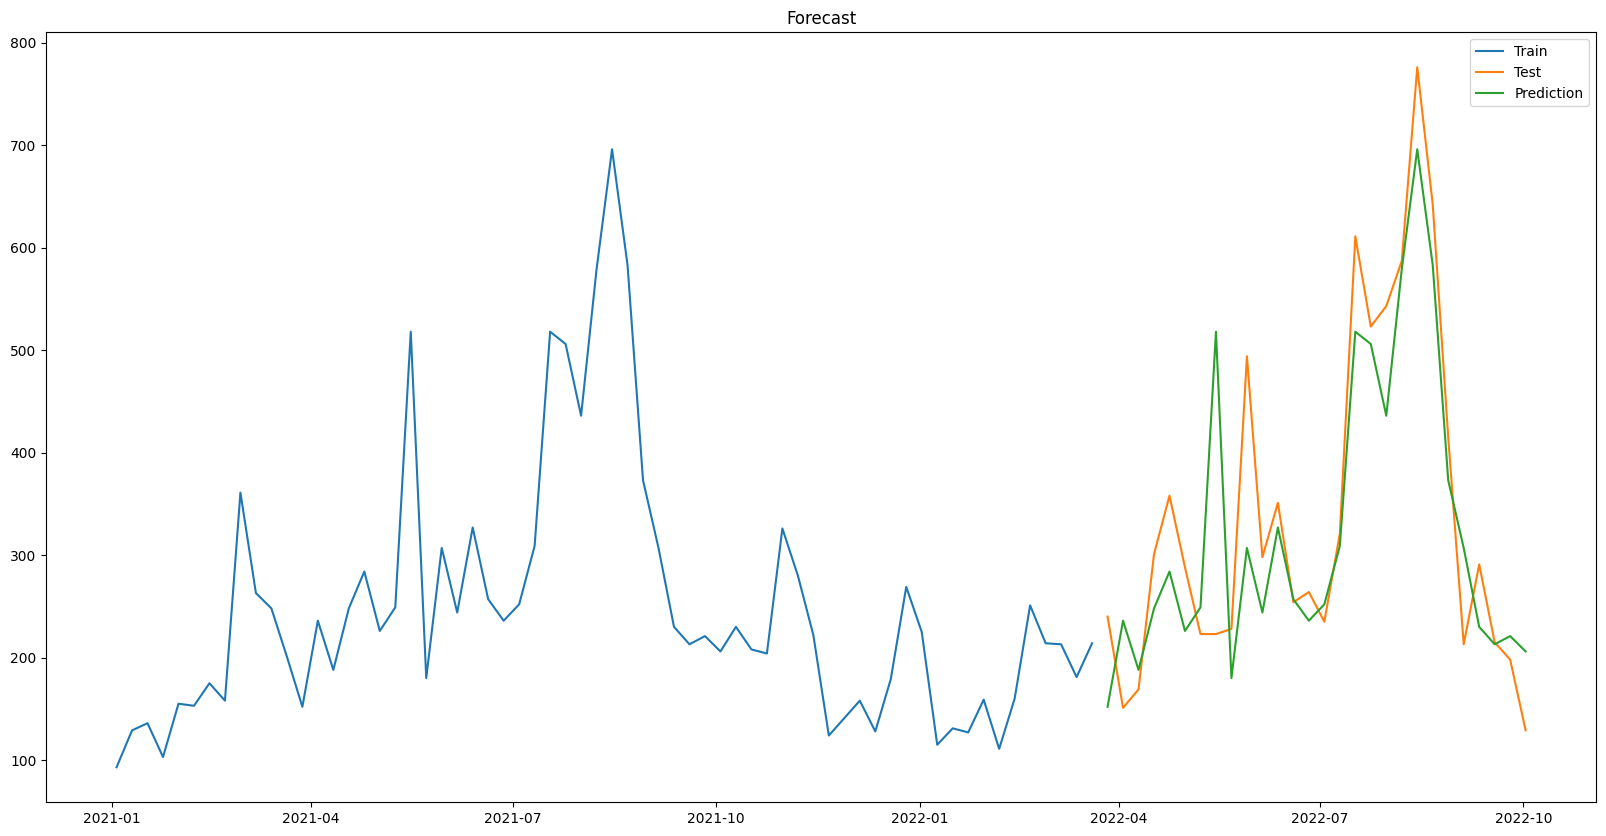

In [22]:
product = df[df['article'] == 'PAIN AU CHOCOLAT']

weekly_sales = product['Quantity'].resample('W').sum()

train = weekly_sales[:int(0.7*len(weekly_sales))]
test = weekly_sales[int(0.7*len(weekly_sales)):]

#Result: order=(0,0,0), seasonal_order=(0,1,0,52)

model = SARIMAX(train, order=(0,0,0), seasonal_order=(0,1,0,52))
model_fit = model.fit()

prediction = pd.DataFrame(model_fit.predict(start= len(train), end=(len(train) + len(test) - 1))).set_index(test.index)

fig, ax = plt.subplots()

ax.plot(train, label = "Train")
ax.plot(test, label = 'Test')
ax.plot(prediction, label = 'Prediction')
ax.set_title('Forecast')
ax.legend()

fig.set_figwidth(20)
fig.set_figheight(10)
fig.show()

In [23]:
r2 = r2_score(test, prediction)
print('r2 score: {}'.format(r2))

r2 score: 0.7275749789810648


C:\Users\Rodney\AppData\Local\Temp\ipykernel_18760\3037950669.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


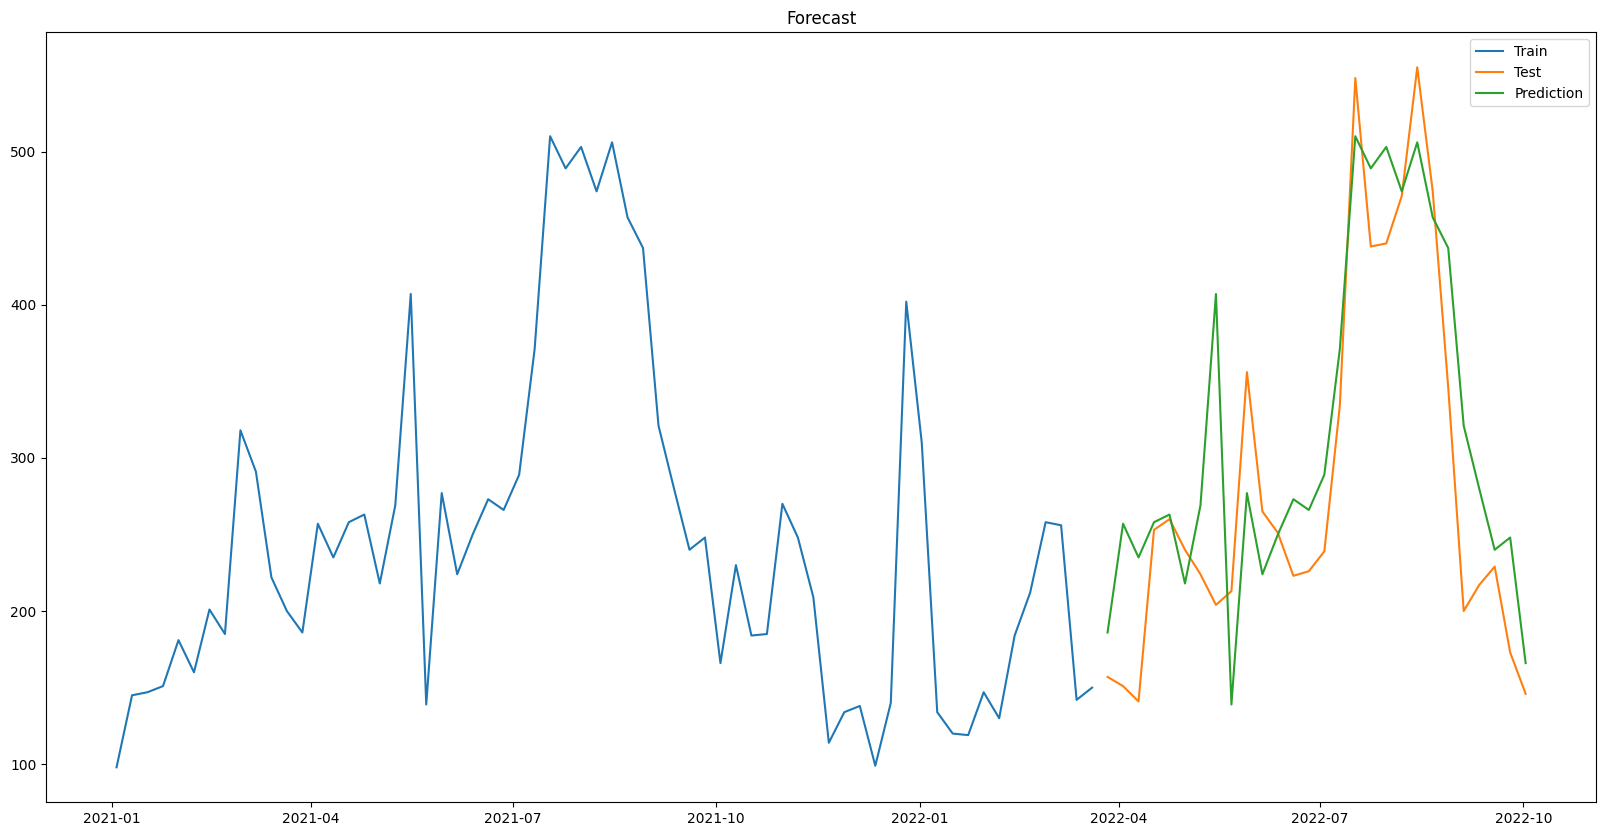

In [24]:
product = df[df['article'] == 'COUPE']

weekly_sales = product['Quantity'].resample('W').sum()

train = weekly_sales[:int(0.7*len(weekly_sales))]
test = weekly_sales[int(0.7*len(weekly_sales)):]

#Result: order=(0,0,0), seasonal_order=(0,1,0,52)

model = SARIMAX(train, order=(0,0,0), seasonal_order=(0,1,0,52))
model_fit = model.fit()

prediction = pd.DataFrame(model_fit.predict(start= len(train), end=(len(train) + len(test) - 1))).set_index(test.index)

fig, ax = plt.subplots()

ax.plot(train, label = "Train")
ax.plot(test, label = 'Test')
ax.plot(prediction, label = 'Prediction')
ax.set_title('Forecast')
ax.legend()

fig.set_figwidth(20)
fig.set_figheight(10)
fig.show()

In [25]:
r2 = r2_score(test, prediction)
print('r2 score: {}'.format(r2))

r2 score: 0.6779935441406181


C:\Users\Rodney\AppData\Local\Temp\ipykernel_18760\2565087571.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


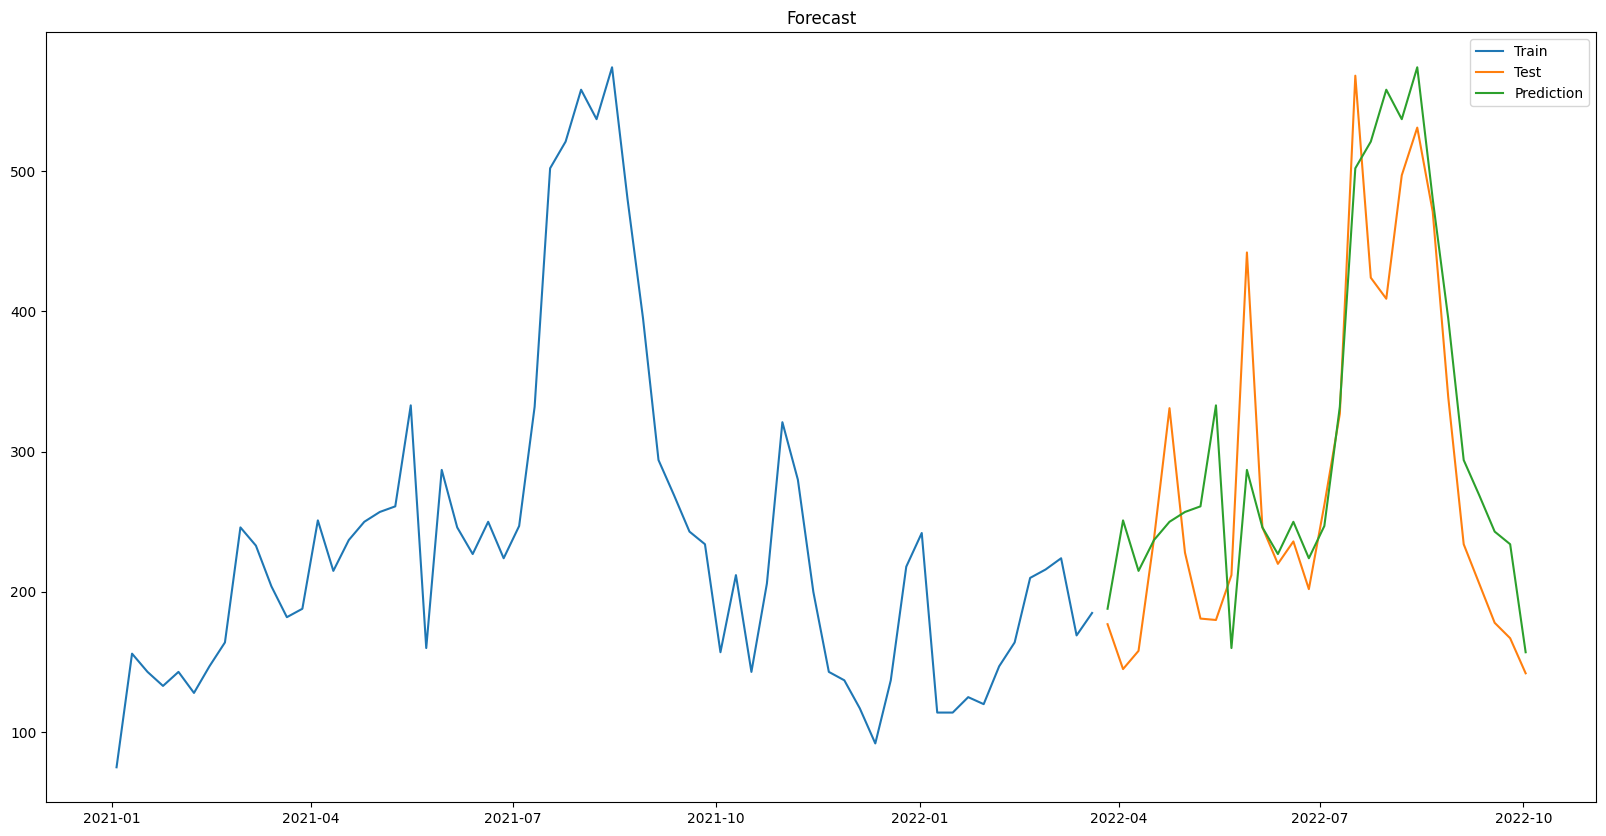

In [26]:
product = df[df['article'] == 'BANETTE']

weekly_sales = product['Quantity'].resample('W').sum()

train = weekly_sales[:int(0.7*len(weekly_sales))]
test = weekly_sales[int(0.7*len(weekly_sales)):]

#Result: order=(0,0,0), seasonal_order=(0,1,0,52)

model = SARIMAX(train, order=(0,0,0), seasonal_order=(0,1,0,52))
model_fit = model.fit()

prediction = pd.DataFrame(model_fit.predict(start= len(train), end=(len(train) + len(test) - 1))).set_index(test.index)

fig, ax = plt.subplots()

ax.plot(train, label = "Train")
ax.plot(test, label = 'Test')
ax.plot(prediction, label = 'Prediction')
ax.set_title('Forecast')
ax.legend()

fig.set_figwidth(20)
fig.set_figheight(10)
fig.show()

In [27]:
r2 = r2_score(test, prediction)
print('r2 score: {}'.format(r2))

r2 score: 0.682328092458024


C:\Users\Rodney\AppData\Local\Temp\ipykernel_18760\2477235829.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


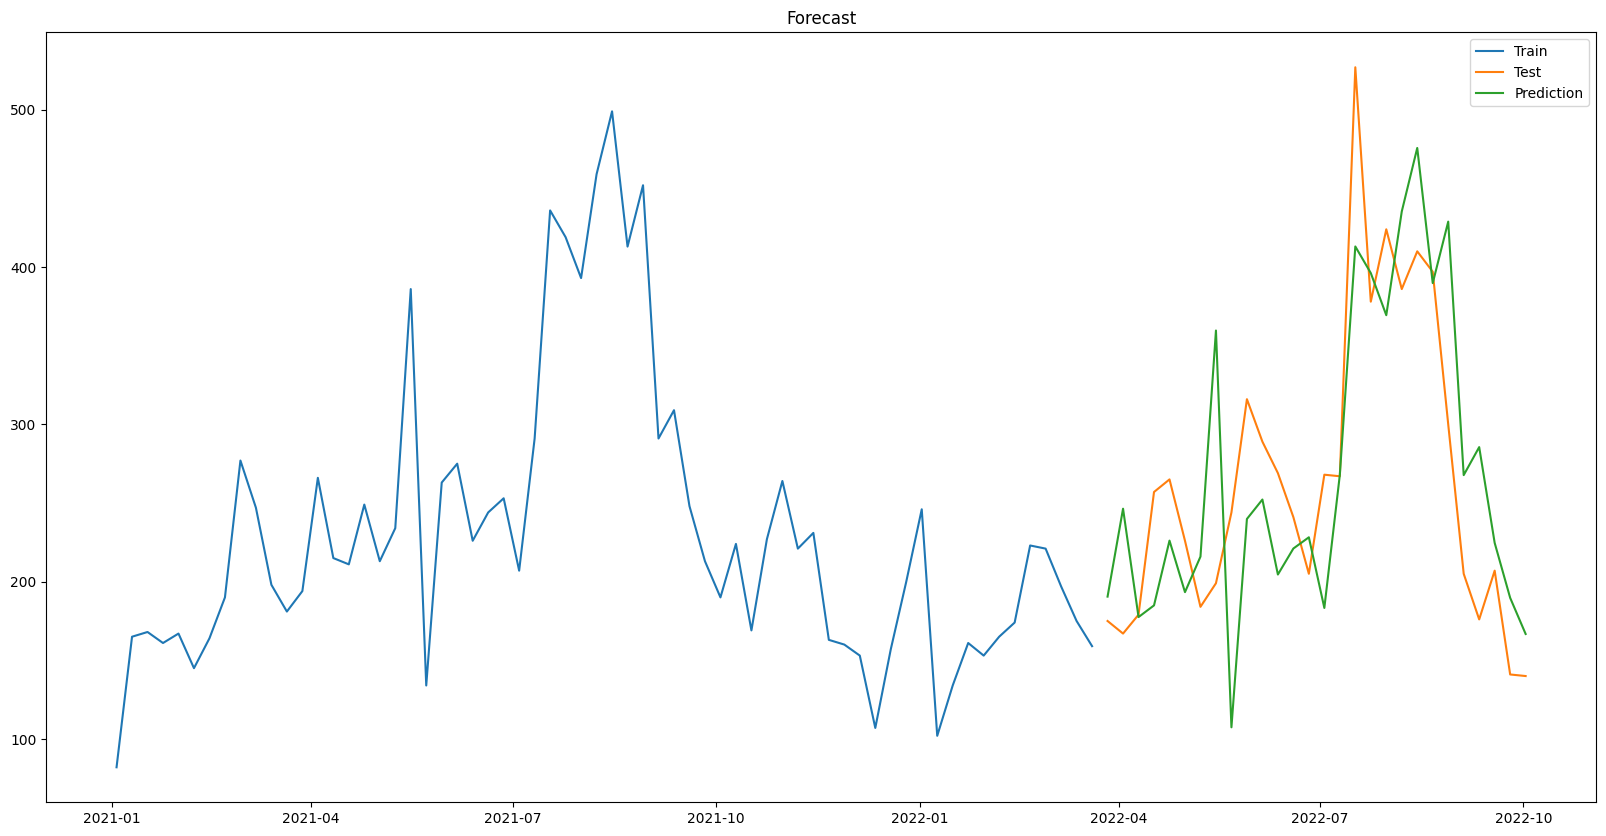

In [28]:
product = df[df['article'] == 'BAGUETTE']

weekly_sales = product['Quantity'].resample('W').sum()

train = weekly_sales[:int(0.7*len(weekly_sales))]
test = weekly_sales[int(0.7*len(weekly_sales)):]

#Result: order=(0,0,0), seasonal_order=(0,1,0,52)

model = SARIMAX(train, order=(5,1,0), seasonal_order=(0,1,0,52))
model_fit = model.fit()

prediction = pd.DataFrame(model_fit.predict(start= len(train), end=(len(train) + len(test) - 1))).set_index(test.index)

fig, ax = plt.subplots()

ax.plot(train, label = "Train")
ax.plot(test, label = 'Test')
ax.plot(prediction, label = 'Prediction')
ax.set_title('Forecast')
ax.legend()

fig.set_figwidth(20)
fig.set_figheight(10)
fig.show()

In [29]:
r2 = r2_score(test, prediction)
print('r2 score: {}'.format(r2))

r2 score: 0.45204161296328815
